In [29]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

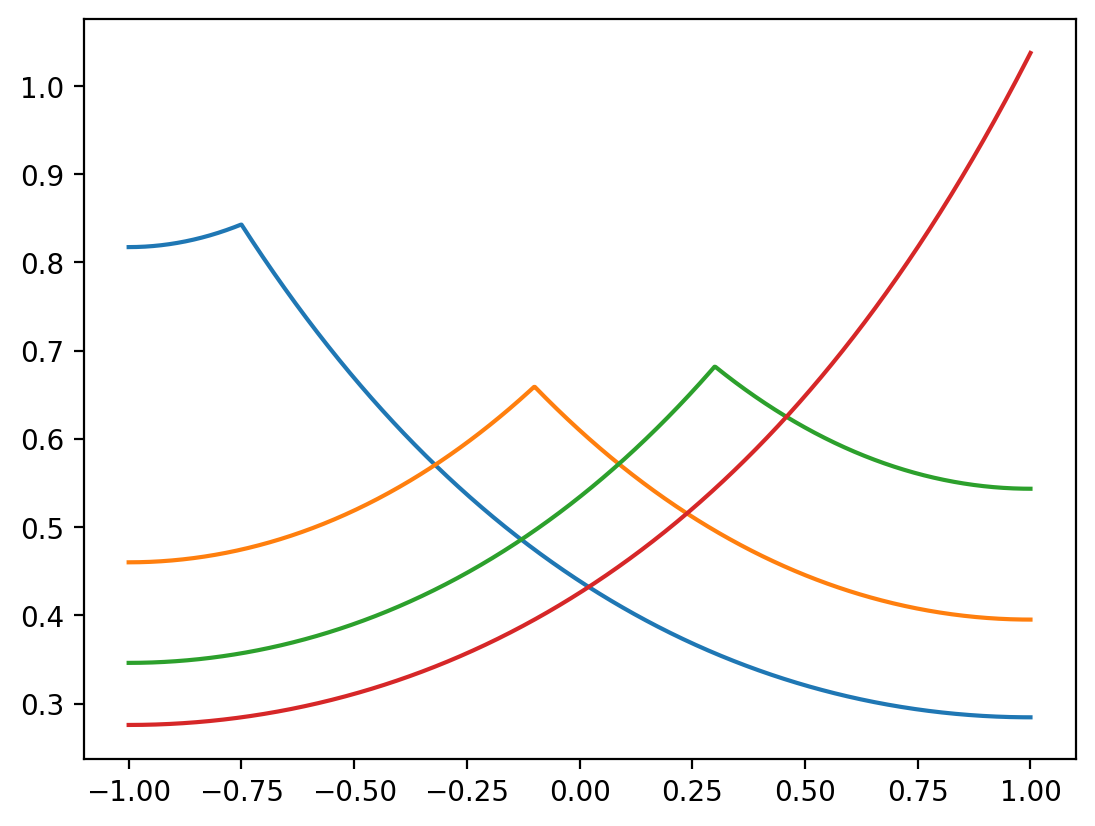

In [121]:
def rkhs_kernel(x, y):
    low = np.minimum(x, y)
    high = np.maximum(x, y)
    return np.cosh(low - domain[0]) * np.cosh(domain[1] - high) / np.sinh(domain[1] - domain[0])

for c in [-0.75, -0.1, 0.3, 1]:
    plt.plot(xs, rkhs_kernel(xs, c))

In [122]:
def dpp_kernel(points):
    points = np.asarray(points)
    assert points.ndim == 1
    K = rkhs_kernel(points[:, None], points[None])
    assert K.shape == (len(points), len(points))
    M = h1_legendre(points, np.eye(dimension))
    assert M.shape == (len(points), dimension)
    es, vs = np.linalg.eigh(K)
    assert np.allclose(vs * es @ vs.T, K)
    M = vs.T @ M
    return M.T * es @ M

In [123]:
def mu_W(points):
    es = np.linalg.eigvalsh(dpp_kernel(points))
    es = np.maximum(es, 0)
    return 1 / np.sqrt(np.min(es))

def quasi_optimality_constant(points):
    return 1 + 2 * mu_W(points)

def mu_p(points, p):
    assert p == 2
    M = h1_legendre(points, np.eye(dimension))
    return np.linalg.norm(M, ord=-2)

def bias_constant(points):
    return 1 + 2 * mu_p(points, 2)

In [124]:
def regeress_optimally(function, points, dimension):
    points = np.asarray(points)
    assert points.ndim == 1
    f = function(points)
    assert f.shape == (len(points),)
    M = h1_legendre(points, np.eye(dimension))
    assert M.shape == (len(points), dimension)
    K = rkhs_kernel(points[:, None], points[None])
    es, vs = np.linalg.eigh(K)
    assert np.allclose(vs * es @ vs.T, K)
    assert np.all(es >= -1e-12)
    es = np.maximum(es, 0)
    K_plus = vs / es @ vs.T
    V = M.T @ K_plus @ M
    v = M.T @ K_plus @ f
    return np.linalg.solve(V, v)

Quasi-optimality: 174.74
Bias: 1.09


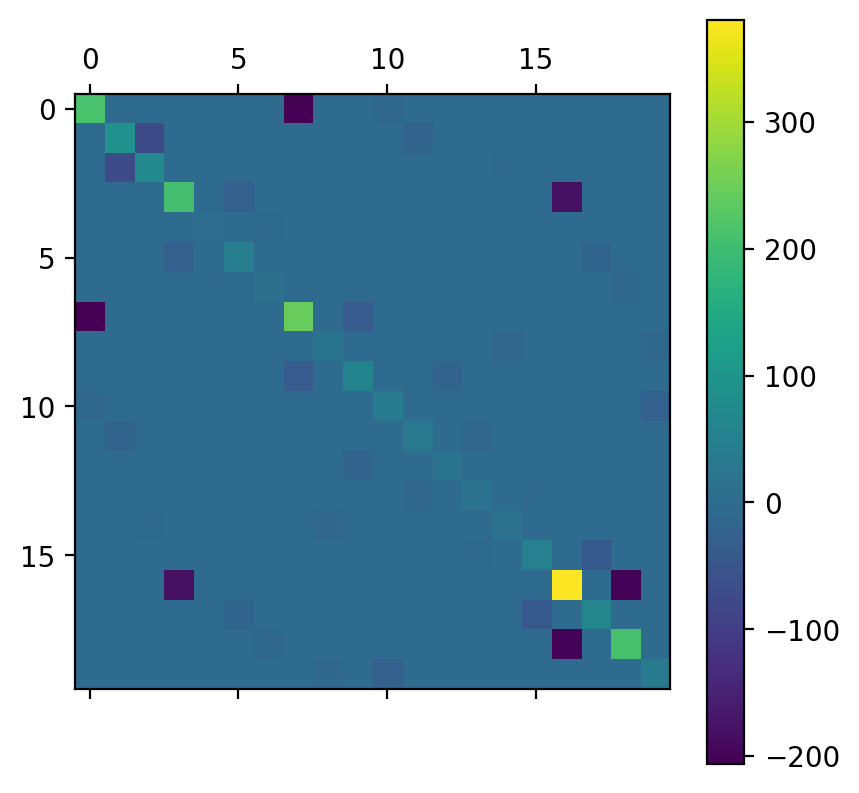

In [125]:
points = 2 * np.random.rand(2 * dimension) - 1

c1 = quasi_optimality_constant(points)
c2 = bias_constant(points)
print(f"Quasi-optimality: {c1:.2f}")
print(f"Bias: {c2:.2f}")

K = rkhs_kernel(points[:, None], points[None])
K_plus = np.linalg.pinv(K)
plt.matshow(K_plus)
plt.colorbar()

[  4.21093337 -10.73885533 -10.21701255  17.05828556  -6.53800138
   3.36557297   1.28714799  -3.33162986   2.29546244  -1.11196016]
[ 0.53522263  0.04467367 -0.90333804  0.80679942 -0.7451009   0.29792936
  0.04882011 -0.27591803  0.24383857  0.03203837]
[ 4.7082302   5.74223009  1.2056571   2.5317635   2.36060798 -5.08004735
  2.97701426 -2.29621732 -0.96147287  0.72950365]


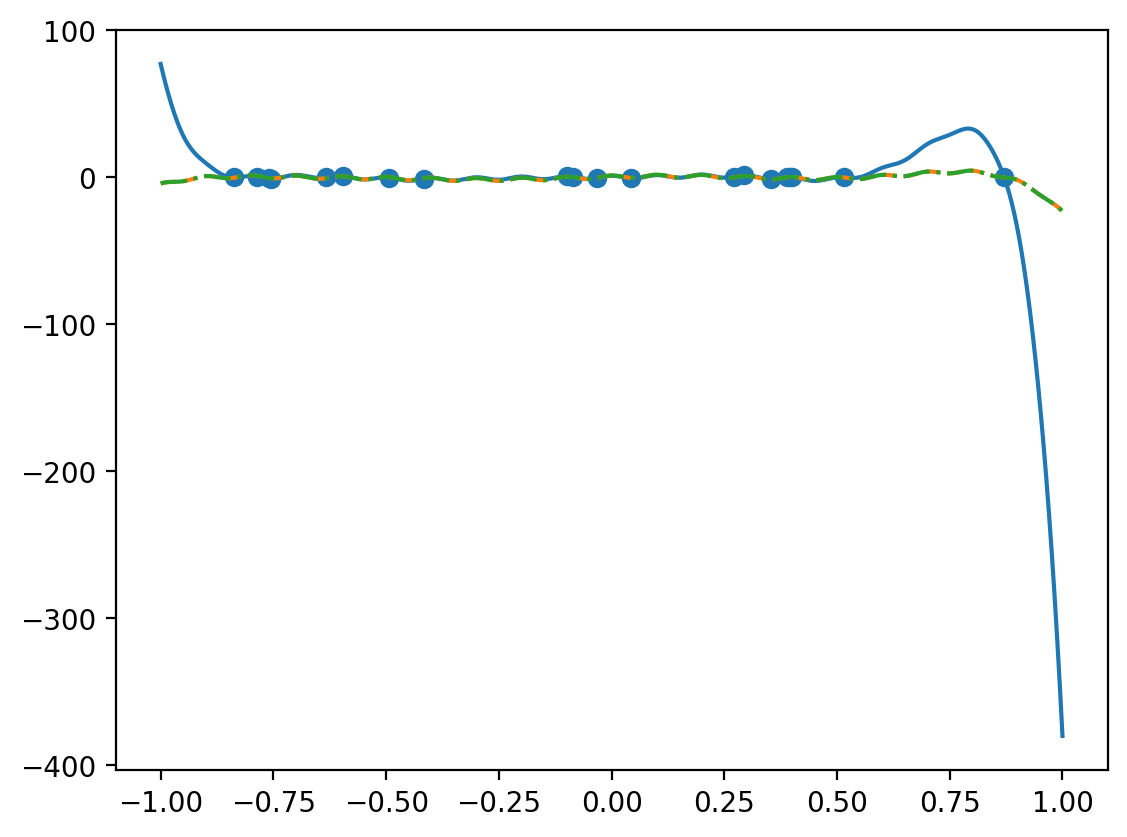

In [127]:
target = lambda x: np.sin(2 * np.pi * x) + np.cos(2 * dimension * np.pi * x)

c = regeress_optimally(target, points, dimension)
print(c)
error = target(xs) - h1_legendre(xs, c)
node_errors = target(points) - h1_legendre(points, c)
plt.plot(xs, error, "C0-")
plt.plot(points, node_errors, "C0o")
c = np.linalg.lstsq(h1_legendre(points, np.eye(dimension)), target(points), rcond=None)[0]
print(c)
error = target(xs) - h1_legendre(xs, c)
plt.plot(xs, error, "C1--")
c = np.linalg.lstsq(h0_legendre(points, np.eye(dimension)), target(points), rcond=None)[0]
print(c)
error = target(xs) - h0_legendre(xs, c)
plt.plot(xs, error, "C2-.")

# Sampling

## Computing the sampling density

In [17]:
d = 3
X = np.random.randn(d+2, d)
det = np.linalg.det(X.T @ X)
prec_det = 1
while X.shape[1] > 0:
    x1 = X[:, 0]
    X = X[:, 1:]
    projection = X @ np.linalg.pinv(X.T @ X) @ X.T
    projection_det = x1 @ x1 - x1 @ projection @ x1
    prec_det *= projection_det
    remaining_det = np.linalg.det(X.T @ X)
    assert np.isclose(prec_det * remaining_det, det)
assert np.allclose(projection, 0)

Text(0.5, 1.0, 'Eigenfunctions of the kernel')

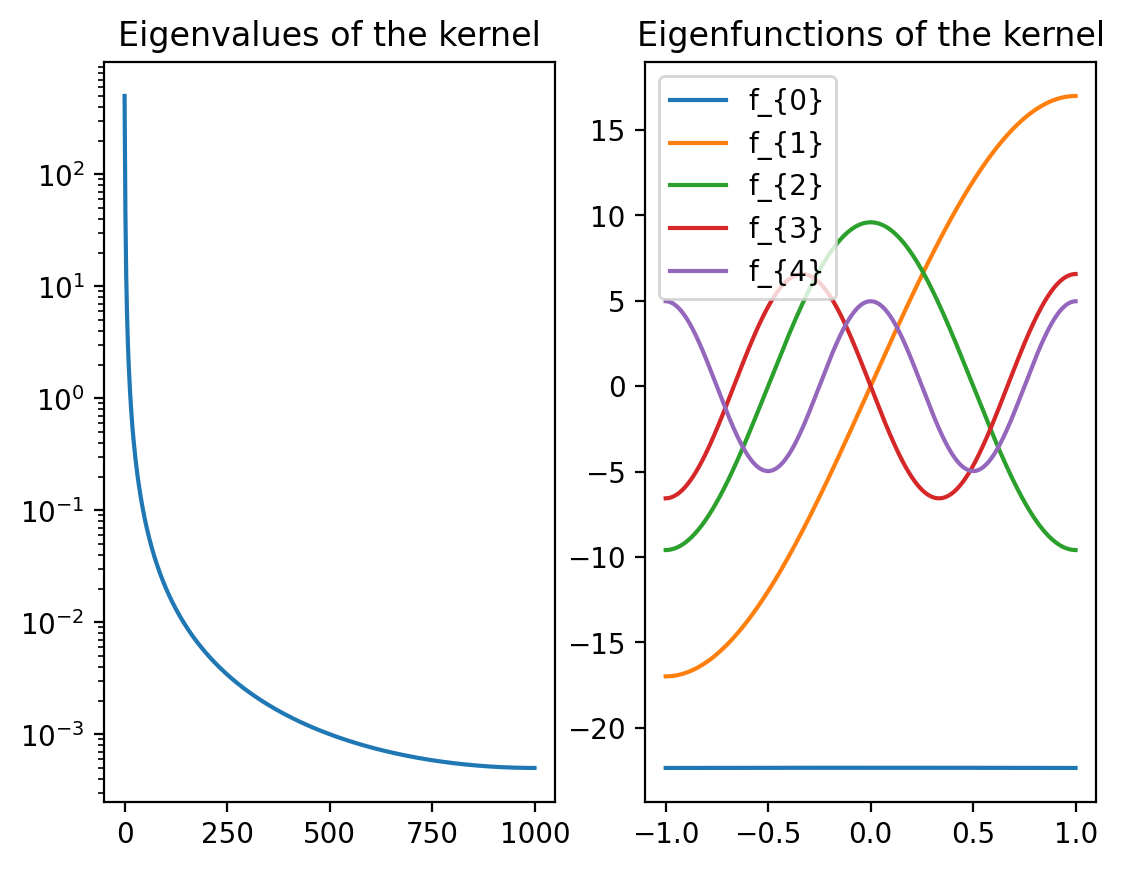

In [129]:
R = 3 * dimension

K = rkhs_kernel(xs[:, None], xs[None])
sigmas, es = np.linalg.eigh(K)
sigmas, es = sigmas[::-1], es[:, ::-1]
assert np.allclose(es * sigmas @ es.T, K)
assert np.all(sigmas[:-1] >= sigmas[1:])
fig, ax = plt.subplots(1, 2)
ax[0].plot(sigmas)
ax[0].set_yscale("log")
ax[0].set_title("Eigenvalues of the kernel")

fs = es[:, :R]
fs /= np.sqrt(np.trapz(fs**2, xs, axis=0) / 2)
fs *= np.sqrt(sigmas[:R])
fs = fs.T
assert fs.shape == (R, len(xs))

for k in range(5):
    ax[1].plot(xs, fs[k], label=f"f_{{{k}}}")
ax[1].legend()
ax[1].set_title("Eigenfunctions of the kernel")

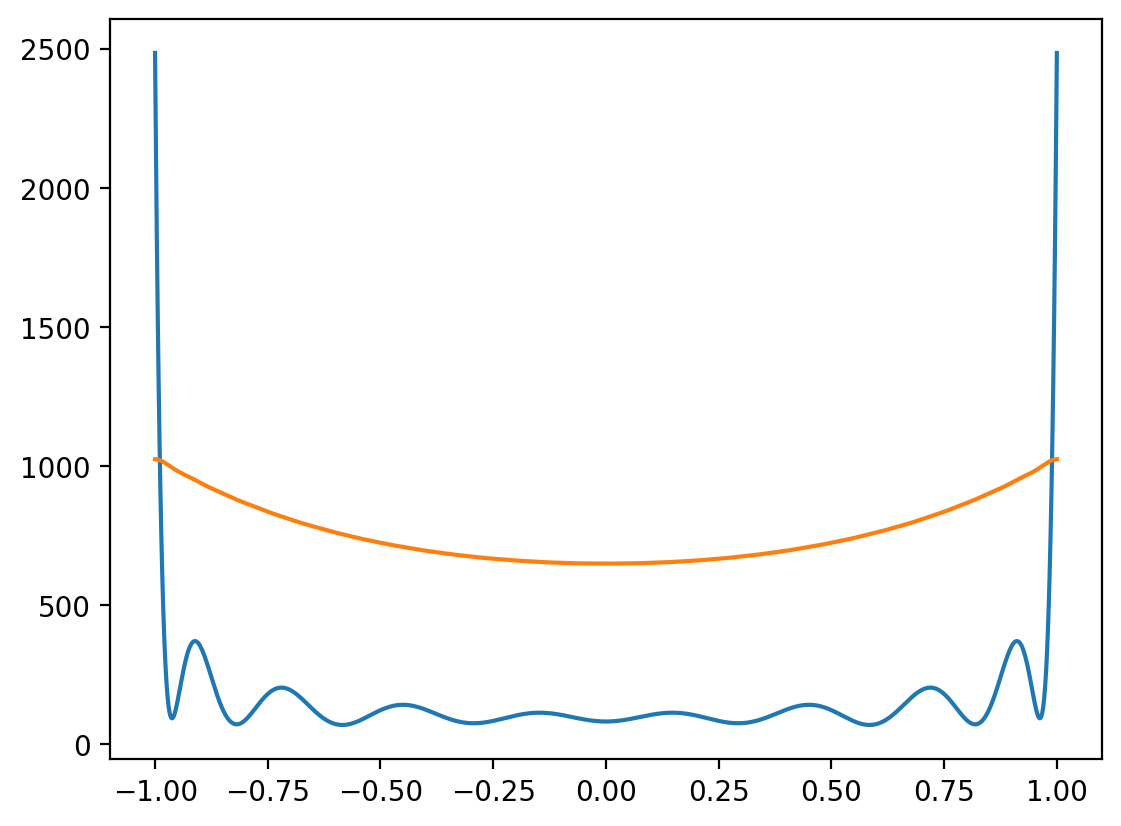

In [132]:
bs = h1_legendre(xs, np.eye(dimension)).T
assert bs.shape == (dimension, len(xs))

ch_b = np.sum(bs**2, axis=0)
ch_f = np.sum(fs**2, axis=0)
plt.plot(xs, ch_b)
plt.plot(xs, ch_f)

In [146]:
def sample(sample_indices=None):
    if sample_indices is None:
        sample_indices = []
    assert isinstance(sample_indices, list) and len(sample_indices) <= dimension <= R
    if len(sample_indices) == dimension:
        return sample_indices
    f_factor = fs[:, sample_indices]
    f_projection = f_factor @ np.linalg.solve(f_factor.T @ f_factor, f_factor.T)
    f_ch = np.einsum("dx, dx -> x", fs, fs) - np.einsum("dx, de, ex -> x", fs, f_projection, fs)
    b_factor = bs[:, sample_indices]
    b_projection = b_factor @ np.linalg.solve(b_factor.T @ b_factor, b_factor.T)
    b_ch = np.einsum("dx, dx -> x", bs, bs) - np.einsum("dx, de, ex -> x", bs, b_projection, bs)
    pdf = b_ch / f_ch
    pdf = np.maximum(pdf, 0)
    pdf /= np.sum(pdf)
    sample_indices.append(np.random.choice(len(xs), p=pdf))
    return sample(sample_indices)

idcs = sample()
print(idcs)
print(list(sorted(xs[idcs])))

[84, 128, 399, 524, 13, 36, 980, 993, 994, 999]
[-0.973973973973974, -0.9279279279279279, -0.8318318318318318, -0.7437437437437437, -0.20120120120120122, 0.04904904904904894, 0.9619619619619619, 0.987987987987988, 0.98998998998999, 1.0]
